### Exemplo: Superfícies circular e elíptica com GDE

Neste exemplo comparamos o comportamento do gradiente descendente estocástico (GDE) em superfícíes com formatos diferentes: circular e elíptica.

Usamos as mesmas funções objetivo e hipótese em ambos os casos, sendo a única diferença o intervalo de variação de um dos atributos.

O GDE usa os mesmo passo de aprendizagem e número de épocas em ambos os casos.

In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import random

### Definição de funções.

In [2]:
# learning schedule: Decaimento temporal
def timeBasedDecay(alpha_int, k, t):
    return alpha_int / (1 + k*t)

# learning schedule: Exponential Decay.
def exponentialDecay(alpha_int, k, t):
    return alpha_int * np.exp(-k*t)

def stepDecay(alpha_int, t, drop=0.5, epochs_drop = 4.0):
    alpha = alpha_int * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

def learning_schedule(typels, alpha_int, t, k=0.01, mu=0.9):
    if(typels=='exp'):
        mom = 0.0
        alpha = exponentialDecay(alpha_int, k, t)
    elif(typels=='time'):
        mom = 0.0
        alpha = timeBasedDecay(alpha_int, k, t)
    elif(typels=='step'):
        mom = 0.0
        alpha = stepDecay(alpha_int, t)
    elif(typels=='mom'):
        mom = mu
        alpha = alpha_int
    elif(typels=='momstep'):
        mom = mu
        alpha = stepDecay(alpha_int, t)
    else:
        mom = 0.0
        alpha = alpha_int
    return alpha, mom

def sgd(X, y_noisy, n_epochs, typels, alpha_init, k=0.01, mu=0.9, seed=42):
    '''Stocastic Gradient Descent implementation.'''
    
    # Reset pseudo-random generator.
    random.seed(seed)
    
    # Number of examples.
    N = len(y_noisy)
    
    # Random initialization of parameters.
    a = np.array([-6.0, -6.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*N+1))

    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*N))

    # Momentum term.
    v = np.zeros((2, 1))

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*N+1)

    # Calculate initial MSE.
    Jgd[0] = (1.0/N)*sum(np.power(y_noisy - X.dot(a), 2))

    update_hist = np.zeros((2, n_epochs*N))

    # Stocastic gradient-descent loop.
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_indexes = random.sample(range(0, N), N)  

        for i in range(N):
            # Retrieve one pair of attribute vector and label.
            random_index = shuffled_indexes[i]
            xi = X[random_index:random_index+1]
            yi = y_noisy[random_index:random_index+1]

            # Update the learning rate value.
            alpha, mu = learning_schedule(typels, alpha_init, (epoch*N + i), k, mu)
            
            # Estimate the gradient with just one sample.
            gradient = -2.0*xi.T.dot(yi - xi.dot(a))
            
            # Update the weights with the momentum term.
            v = mu*v - alpha*gradient
            a = a + v

            # Update arrays with history values.
            a_hist[:, epoch*N+i+1] = a.reshape(2,)
            update_hist[:, epoch*N+i] = v.reshape(2,)
            alpha_hist[epoch*N+i] = alpha

            # Calculate the current MSE.
            Jgd[epoch*N+i+1] = (1.0/N)*sum(np.power((y_noisy - X.dot(a)), 2))

    return a, Jgd, a_hist, update_hist, alpha_hist

### Superfície circular.

In [3]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [4]:
# Define the number of examples.
N = 1000

# Features.
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [5]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-6.0, 8.0, M)
a2 = np.linspace(-6.0, 8.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
        J[iter1][iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

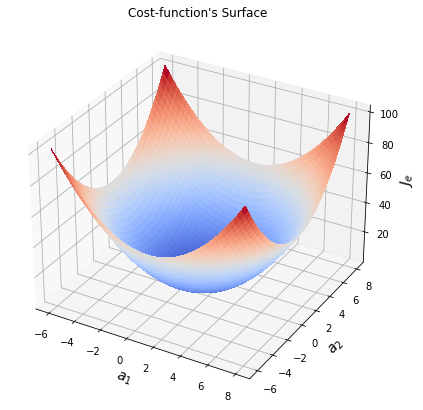

In [6]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [7]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

# Hypothesis function.
yhat = X.dot(a_opt)

# Mean Squared Error.
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('Joptimum:', Joptimum)

Joptimum: 0.9692215285411727


In [8]:
# Number of epochs.
n_epochs = 1

# Constant learning rate.
alpha_sgd = 0.004

a_sgd, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'none', alpha_sgd, 0.01, 0.0, seed)

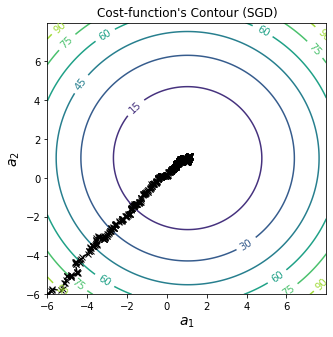

In [9]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-6, 8, step=2.0))
plt.yticks(np.arange(-6, 8, step=2.0))
plt.show()

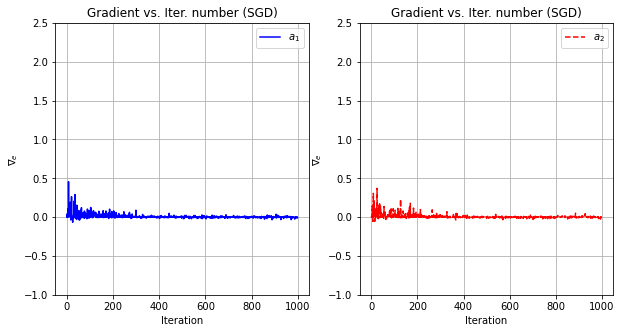

In [10]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()
ax2.grid()

plt.show()

In [11]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.0007805471081685804
var a2: 0.0008085325335477878


### Superfície elíptica.

In [12]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [13]:
# Define the number of examples.
N = 1000

# Features.
x1 = 10*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [14]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-7.0, 8.0, M)
a2 = np.linspace(-7.0, 8.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
        J[iter1, iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

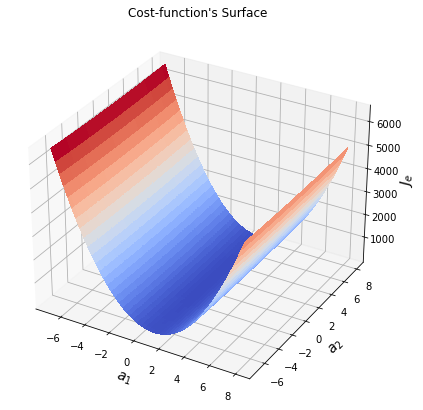

In [15]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [16]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

# Hypothesis function.
yhat = X.dot(a_opt)

# Mean Squared Error.
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))
print('Joptimum:', Joptimum)

Joptimum: 0.9692215285411728


In [17]:
# Number of epochs.
n_epochs = 1

# Constant learning rate.
alpha_sgd = 0.004

a_sgd, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'none', alpha_sgd, 0.01, 0.0, seed)

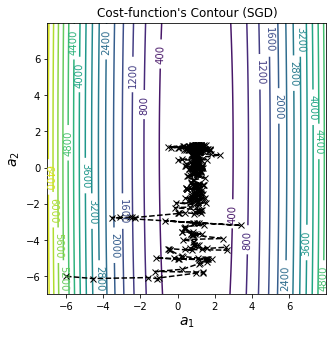

In [18]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J, levels=20)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-6, 8, step=2.0))
plt.yticks(np.arange(-6, 8, step=2.0))
plt.show()

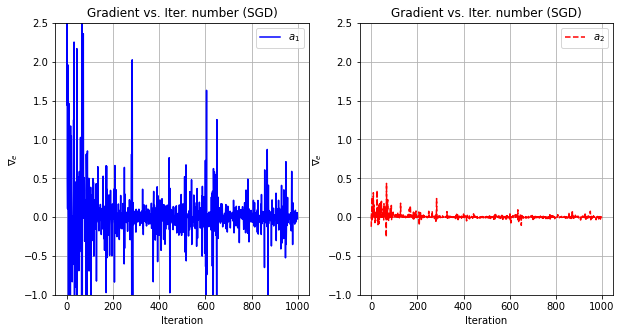

In [19]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()
ax2.grid()

plt.show()

In [20]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.18916784640413792
var a2: 0.0013627890005954476


### Superfície elíptica com termo momentum.

In [21]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [22]:
# Define the number of examples.
N = 1000

# Features.
x1 = 10*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [23]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-6.0, 8.0, M)
a2 = np.linspace(-6.0, 8.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
        J[iter1][iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

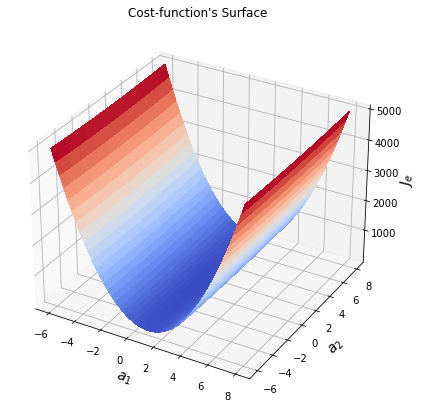

In [24]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [25]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

yhat = X.dot(a_opt)
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('Joptimum:',Joptimum)

Joptimum: 0.9692215285411728


### Adicionando o termo momentum.

+ O coeficiente de momentum, $\mu$, controla a quantidade de histórico (momentum) a ser incluído na equação de atualização dos pesos.

+ Um grande coeficiente de momentum, por exemplo, 0.9, significará que a atualização será fortemente influenciada por uma grande quantidade de valores anteriores, enquanto um coeficiente de momentum pequeno, por exemplo 0.2, significará uma influência muito pequena do histórico.

In [26]:
# Number of epochs.
n_epochs = 1

# Constant learning rate.
alpha_mom = 0.0006

# Coefficient of momentum.
mu = 0.7

# SGE with momentum term.
a_mom, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'mom', alpha_mom, 0.01, mu, seed)

+ Com o momentum, o tamanho do passo depende do quão grande e quão alinhado uma sequência de gradientes está. 

+ O tamanho do passo é maior quando muitos gradientes sucessivos apontam exatamente para a mesma direção, ou seja, acelera a convergência e suaviza o movimento de zig-zag.

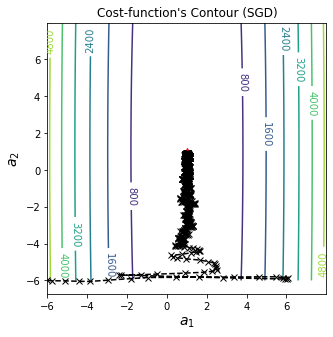

In [27]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-6, 8, step=2.0))
plt.yticks(np.arange(-6, 8, step=2.0))
plt.show()

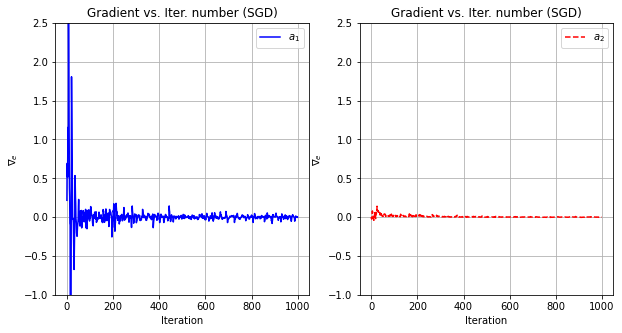

In [28]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()
ax2.grid()

plt.show()

+ O termo momentum tem como objetivo principal resolver o problema da alta variância do gradiente estocástico.

In [29]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.04528954061497671
var a2: 0.0001762128842962509


**Vantagens**

+ O momentum é útil quando o espaço de busca é plano ou quase plano, platô ou uma ravina (uma das dimensões é bastante plana). 

+ O momentum permite que a busca avance na mesma direção anterior à região plana e cruze esta região de forma mais rápida.